In [11]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# SQLite database creation
conn = sqlite3.connect('space_missions.sqlite')
cur = conn.cursor()

tablename = 'records'

df = pd.read_csv('space_missions_normalized.csv', encoding='latin1')
df.to_sql(tablename, conn, if_exists='replace', index=False)

4630

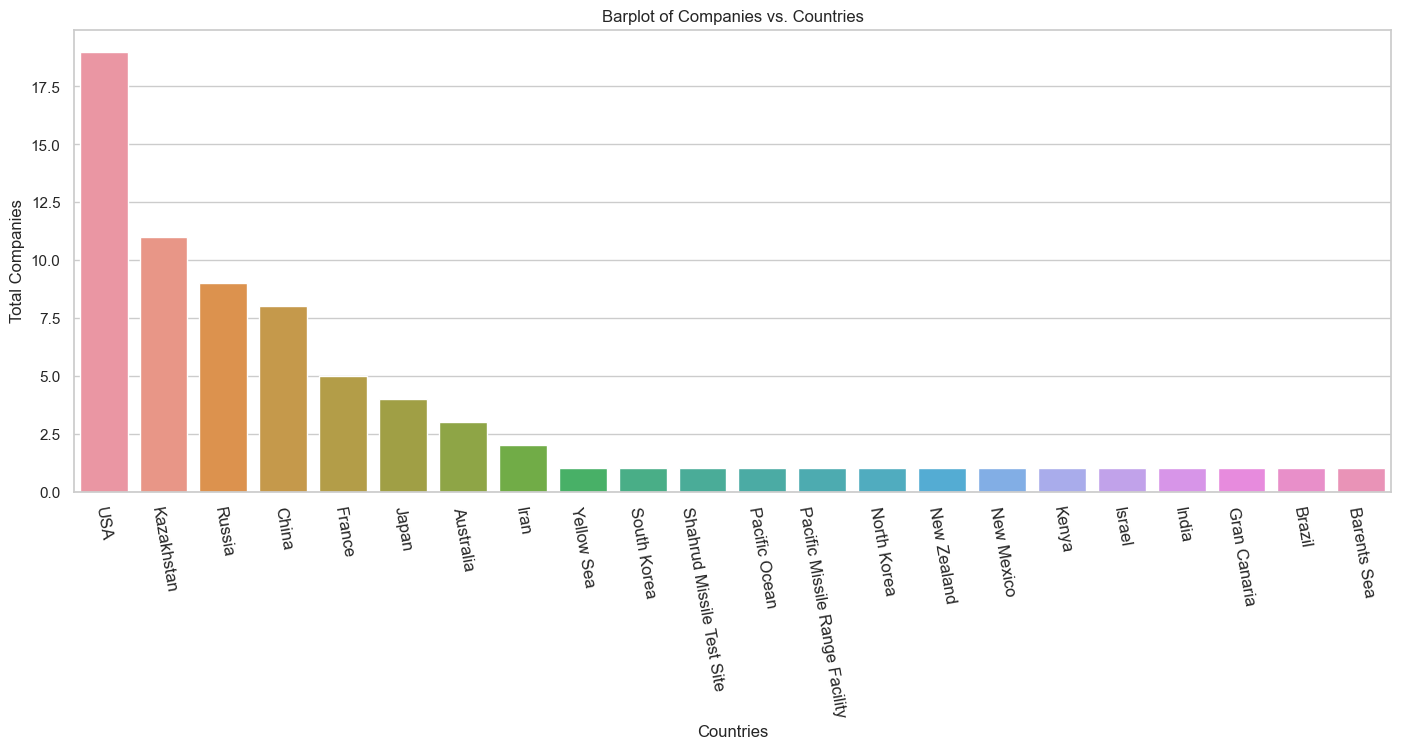

In [13]:
## First analysis query
# List of companies per country
q = '''
SELECT Country, COUNT(DISTINCT Company) AS TotalCompaniesPerCountry
FROM records
GROUP BY Country
ORDER BY TotalCompaniesPerCountry DESC;
'''

query = pd.read_sql_query(q,conn)

# Barplot make
data = query
sns.set(style="whitegrid")
plt.figure(figsize=(17, 6))  

barplot = sns.barplot(x="Country", y="TotalCompaniesPerCountry", data=data)

plt.xlabel("Countries", fontsize=12)
plt.ylabel("Total Companies", fontsize=12)
plt.title("Barplot of Companies vs. Countries", fontsize=12)
plt.xticks(rotation=-80, fontsize=12)
plt.show()


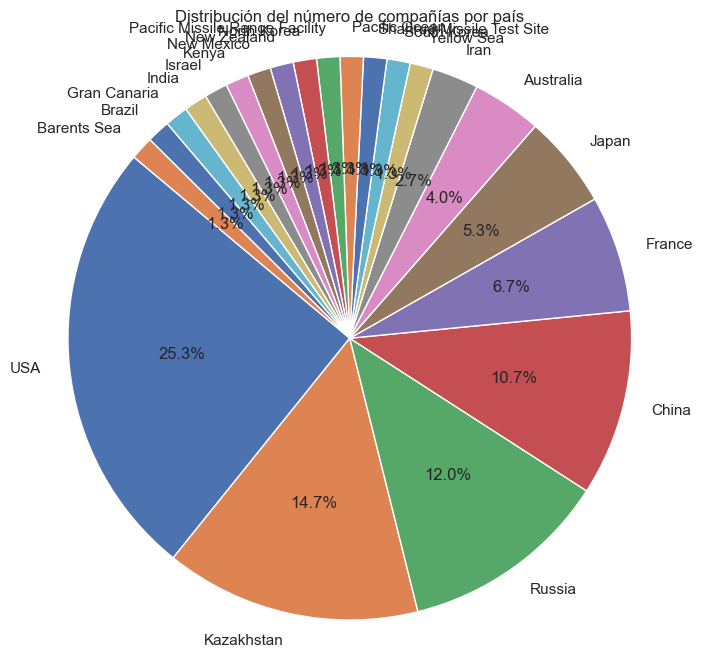

In [14]:
plt.figure(figsize=(8, 8))
plt.pie(query['TotalCompaniesPerCountry'], labels=query['Country'], autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Distribución del número de compañías por país')

plt.show()

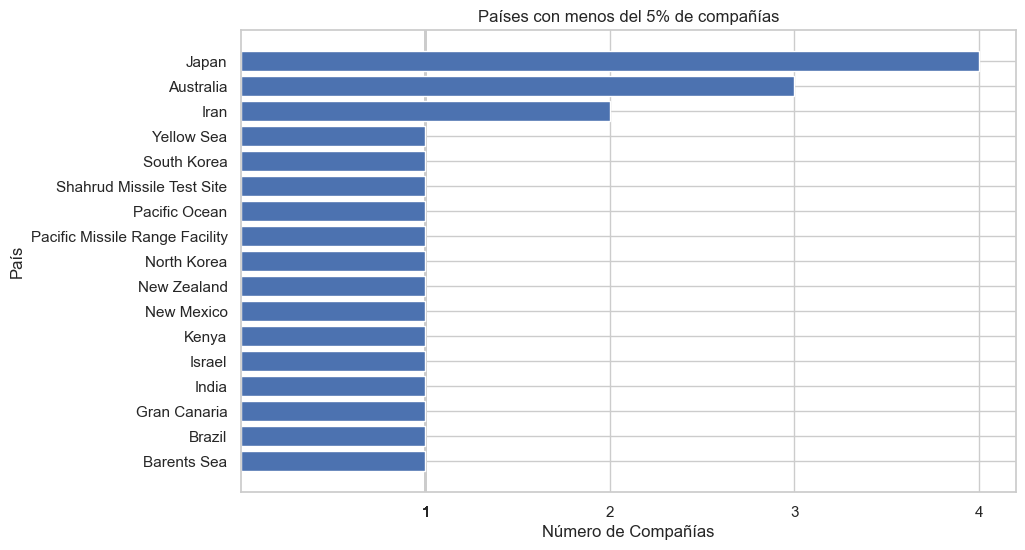

In [15]:
# Due to unclear country names insights I make a barchart: Countries with less than 5% of companies
# Countries with less than 5% of companies
valores_menores_5 = query[query['TotalCompaniesPerCountry'] < 5.0]

# Barchart DESC order
plt.figure(figsize=(10, 6))
plt.barh(valores_menores_5['Country'], valores_menores_5['TotalCompaniesPerCountry'])
plt.xlabel('Número de Compañías')
plt.xticks(valores_menores_5['TotalCompaniesPerCountry'].round(0))
plt.ylabel('País')
plt.title('Países con menos del 5% de compañías')
plt.gca().invert_yaxis()

plt.show()

In [16]:
# Creating a new database to save the insights
conn2 = sqlite3.connect('space_missions_insights.sqlite') 
cur = conn.cursor()

NtableName = 'companies_country'
df2 = pd.read_sql_query(q,conn)
df2.to_sql(NtableName, conn2, if_exists='replace', index=False) 

22

In [17]:
# Top 5 countries with rocket launches
q2 = '''
SELECT Country, COUNT(*) AS TotalLaunches
FROM records
GROUP BY Country
ORDER BY TotalLaunches DESC
LIMIT 5;
'''
NtableName2='total_launches_country'
df3 = pd.read_sql_query(q2, conn)
df3.to_sql(NtableName2, conn2, if_exists='replace', index=False)
df3

,Country,TotalLaunches
0,USA,1467
1,Russia,1416
2,Kazakhstan,719
3,China,365
4,France,318


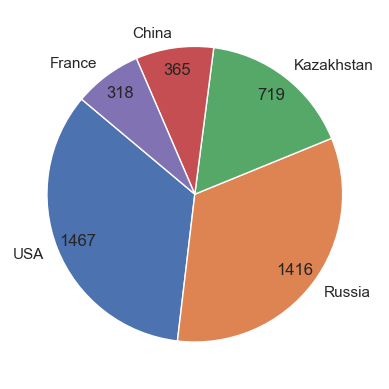

In [18]:
plt.pie(df3['TotalLaunches'], labels=df3['Country'], startangle=140, pctdistance=0.85, autopct=lambda p: '{:.0f}'.format(p * sum(df3['TotalLaunches']) / 100))
plt.show()

In [19]:
# Top 3 with success launches
q3 = '''
SELECT Country, COUNT(*) AS SuccesfullLaunches
FROM records
WHERE MissionStatus = 'Success'
GROUP BY Country
ORDER BY SuccesfullLaunches DESC
LIMIT 3;
'''
NtableName3 = 'top_suc_mission'
df4 = pd.read_sql_query(q3, conn)
df4.to_sql(NtableName3, conn2, if_exists='replace', index=False)

print(df4)

      Country  SuccesfullLaunches
0      Russia                1323
1         USA                1298
2  Kazakhstan                 625


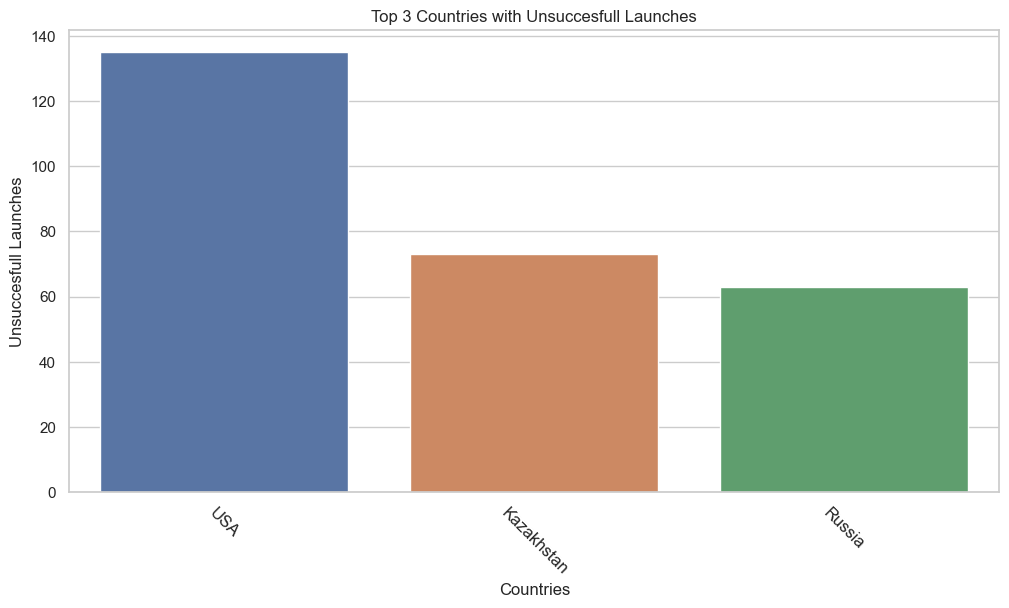

In [20]:
# Top 3 with unsuccessful launches
q4 = '''
SELECT Country, COUNT(*) AS UnsuccessfullLaunches
FROM records
WHERE MissionStatus = 'Failure' OR MissionStatus = 'PartialFailure' OR MissionStatus = 'Prelaunch Failure'
GROUP BY Country
ORDER BY UnsuccessfullLaunches DESC
LIMIT 3;
'''
NtableName4 = 'top_uns_mission'
df5 = pd.read_sql_query(q4, conn)
df5.to_sql(NtableName4, conn2, if_exists='replace', index=False)

data = df5
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))  


barplot = sns.barplot(x="Country", y="UnsuccessfullLaunches", data=data)


plt.xlabel("Countries", fontsize=12)
plt.ylabel("Unsuccesfull Launches", fontsize=12)
plt.title("Top 3 Countries with Unsuccesfull Launches", fontsize=12)
plt.xticks(rotation=-45, fontsize=12)
plt.show()

In [21]:
# Succesfull & Unsuccessfull launches ratio (TOP 10)
q5 = '''
SELECT
    Country,
    SUM(CASE WHEN MissionStatus = 'Success' THEN 1 ELSE 0 END) AS SuccessfulLaunches,
    SUM(CASE WHEN MissionStatus IN ('Failure', 'partialfailure', 'Prelaunchfailure') THEN 1 ELSE 0 END) AS UnsuccessfulLaunches,
    ROUND(
        (SUM(CASE WHEN MissionStatus = 'Success' THEN 1 ELSE 0 END) * 1.0 / NULLIF(SUM(CASE WHEN MissionStatus = 'Failure' THEN 1 ELSE 0 END), 0))
    , 2) AS SuccessToFailureRatio
FROM
    records
GROUP BY
    Country
ORDER BY
    SuccessToFailureRatio DESC
LIMIT 10;
'''

NtableName4 = 'ratios'
df6 = pd.read_sql_query(q5,conn)
df6.to_sql(NtableName4, conn2, if_exists='replace', index=False)

df6

,Country,SuccessfulLaunches,UnsuccessfulLaunches,SuccessToFailureRatio
0,France,299,14,21.36
1,Russia,1323,63,21.00
2,China,335,24,13.96
3,Japan,117,10,11.70
4,Pacific Ocean,33,3,11.00
5,USA,1298,134,9.69
6,Kazakhstan,625,72,8.68
7,New Zealand,25,3,8.33
8,India,68,9,7.56
9,Israel,9,2,4.50
